# KTRLite Examples

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import orbit
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
print(orbit.__version__)
print(matplotlib.__version__)

1.0.14dev
3.3.4


## Data

In [5]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

date_col = 'date'
response_col = 'electricity'

df[response_col] = np.log(df[response_col])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [6]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [7]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [8]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.3,
    estimator_type=StanEstimatorMAP,
    n_bootstrap_draws=1e4,
)

INFO:root:Using 4 chains, 8 cores, 225 warmup and 25 samples per chain for sampling.


In [9]:
ktrlite.fit(train_df)

In [13]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95
0,2008-01-02,9.90247,10.01165,10.12115
1,2008-01-03,9.90110,10.01374,10.12480
2,2008-01-04,9.91657,10.02801,10.14133
3,2008-01-05,9.84234,9.95544,10.06749
4,2008-01-06,9.78407,9.89762,10.01410


In [14]:
'{:.2%}'.format(smape(predicted_df['prediction'].values, test_df['electricity'].values))

'0.46%'

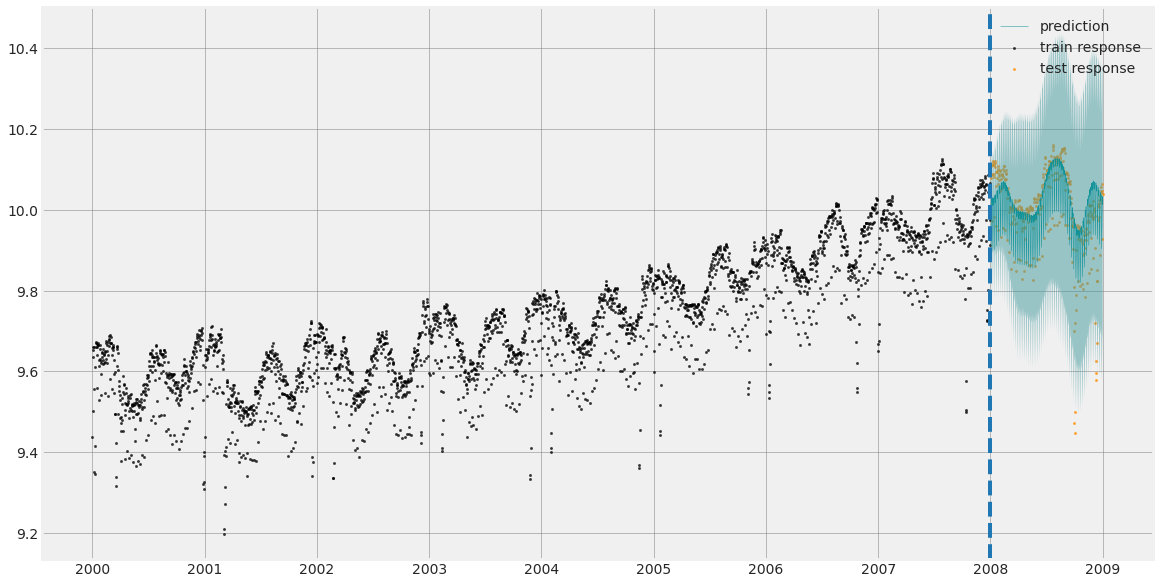

In [15]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=20, lw=.5)

In [16]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1152x576 with 0 Axes>

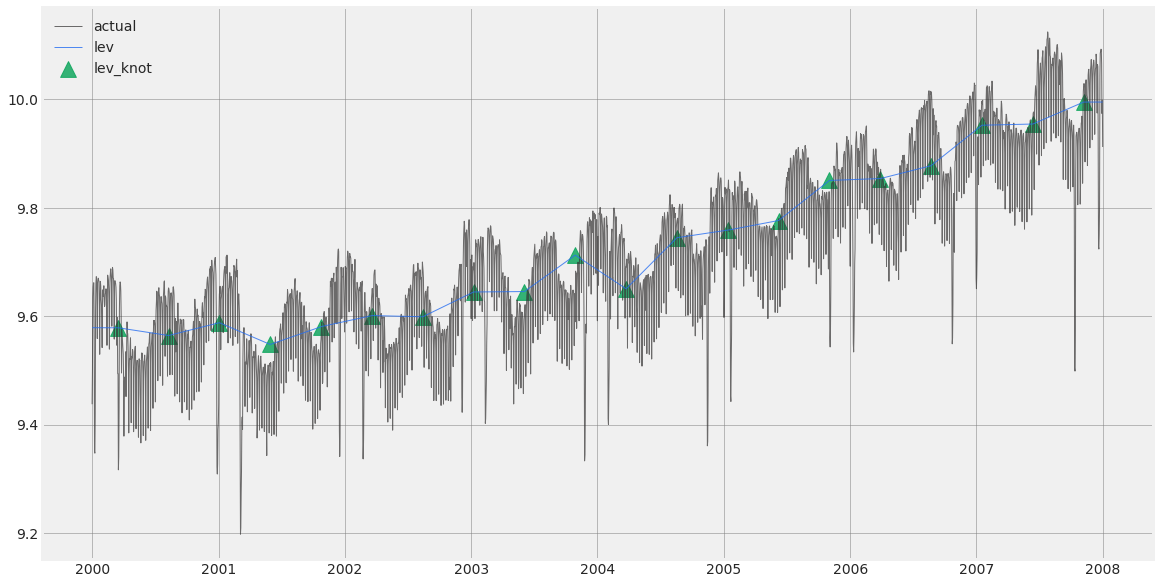

In [17]:
_ = ktrlite.plot_lev_knots()

In [18]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head(5)

,date,lev_knot
0,2000-03-15,9.57878
1,2000-08-09,9.56434
2,2001-01-03,9.58799
3,2001-05-30,9.54782
4,2001-10-24,9.58073


In [19]:
lev_df = ktrlite.get_levels()
lev_df.head(5)

,date,lev
0,2000-01-01,9.57878
1,2000-01-02,9.57878
2,2000-01-03,9.57878
3,2000-01-04,9.57878
4,2000-01-05,9.57878


In [29]:
# stability check
ktrlite1 = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7],
    span_coefficients=.3,
    estimator_type=StanEstimatorMAP,
    n_bootstrap_draws=-1,
    seed=2020,
)

# stability check
ktrlite2 = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7],
    span_coefficients=.3,
    estimator_type=StanEstimatorMAP,
    n_bootstrap_draws=-1,
    seed=2021,
)

ktrlite1.fit(df)
ktrlite2.fit(df)

INFO:root:Using 4 chains, 8 cores, 225 warmup and 25 samples per chain for sampling.
INFO:root:Using 4 chains, 8 cores, 225 warmup and 25 samples per chain for sampling.


In [30]:
np.allclose(ktrlite1._posterior_samples['lev_knot'], ktrlite2._posterior_samples['lev_knot'], rtol=0.001)

True

In [31]:
np.allclose(ktrlite1._posterior_samples['coef_knot'], ktrlite2._posterior_samples['coef_knot'], rtol=0.1)

True